In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from pycaret.regression import *
from pycaret.utils import check_metric
from pycaret.utils import version
version()

'2.2.1'

In [2]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are some missing values in the dataset which has to be dealt with. The Cabin column has very few entries, so this one might be worth dropping all together. 

In [5]:
train.Cabin.value_counts()

C23 C25 C27        4
G6                 4
B96 B98            4
F2                 3
C22 C26            3
F33                3
D                  3
E101               3
B35                2
E24                2
E8                 2
D33                2
C124               2
E67                2
E33                2
B57 B59 B63 B66    2
B18                2
B5                 2
B28                2
E25                2
D26                2
B20                2
C123               2
D17                2
B58 B60            2
C126               2
F G73              2
C68                2
C78                2
E121               2
B22                2
C92                2
C65                2
F4                 2
B49                2
B51 B53 B55        2
D35                2
C83                2
D20                2
D36                2
C2                 2
C52                2
B77                2
C93                2
C125               2
E44                2
D50                1
C101         

In [6]:
cabins = train.loc[train.Cabin.notnull()]["Survived"]
cabinSurv = sum(cabins)/len(cabins)
print(cabinSurv)

0.6666666666666666


In [7]:
cabins = train.loc[train.Cabin.isna()]["Survived"]
cabinSurv = sum(cabins)/len(cabins)
print(cabinSurv)

0.29985443959243085


After checking the people who gave their cabin compared to those who didn't, you can see a huge difference in survivalrate if the cabin was given. If we want to take it one step further, we can see if the letter before the cabin changes the survival rate.

In [8]:
train['Cabin'] = train['Cabin'].str[0]
train['Cabin'] = train['Cabin'].replace(np.nan, 'X')

In [9]:
train.Cabin.value_counts()

X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

The Ticket column can probably be dropped safely as the Fare price will be a better indicator of what ticket they had. For the Name, the last name might have some impact on survivalrate, but in order to do so, you would have to make it categorical, and I believe the model would suffer more from it.

In [10]:
train = train.drop(columns=['Ticket','Name'])

In [11]:
#train['Sex'] = train['Sex'].replace(['male'], 0)
#train['Sex'] = train['Sex'].replace(['female'], 1)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        891 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [13]:
reg_setup2 = setup(train, target='Survived', train_size=.95, numeric_features = ['SibSp','Parch'], 
                   numeric_imputation='median', normalize=True, normalize_method='robust')

,Description,Value
0,session_id,2761
1,Target,Survived
2,Original Data,"(891, 10)"
3,Missing Values,True
4,Numeric Features,5
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(846, 21)"


In [14]:
top_4 = compare_models(n_select=4, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2614,0.1333,0.3642,0.4341,0.2557,0.3473,0.0240
catboost,CatBoost Regressor,0.2517,0.1359,0.3677,0.4231,0.2578,0.3321,0.7250
lightgbm,Light Gradient Boosting Machine,0.2684,0.1421,0.3758,0.3965,0.2647,0.3367,0.0180
rf,Random Forest Regressor,0.2419,0.1434,0.3775,0.3909,0.2663,0.3063,0.0810
br,Bayesian Ridge,0.2983,0.1446,0.3796,0.3863,0.2683,0.3874,0.0050
ada,AdaBoost Regressor,0.3181,0.1448,0.3801,0.3860,0.2746,0.3484,0.0110
ridge,Ridge Regression,0.2966,0.1450,0.3802,0.3842,0.2686,0.3864,0.0050
lr,Linear Regression,0.2965,0.1454,0.3807,0.3827,0.2689,0.3867,0.3100
omp,Orthogonal Matching Pursuit,0.3055,0.1531,0.3907,0.3501,0.2766,0.3977,0.0040
xgboost,Extreme Gradient Boosting,0.2487,0.1582,0.3958,0.3281,0.2738,0.3134,0.1870


In [15]:
top_models = top_4[1:]

In [16]:
top_models

 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2761, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2761, verbose=0, warm_start=False)]

In [17]:
tuned_top_models = [tune_model(model, optimize='RMSE', choose_better=True)
                   for model in top_models]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2915,0.1361,0.3689,0.4040,0.2583,0.4038
1,0.2679,0.1182,0.3439,0.4896,0.2525,0.2579
2,0.2800,0.1264,0.3556,0.4732,0.2475,0.3779
3,0.2951,0.1272,0.3566,0.4645,0.2532,0.3648
4,0.3015,0.1377,0.3711,0.4313,0.2599,0.3815
5,0.3158,0.1496,0.3868,0.3824,0.2612,0.4807
6,0.3224,0.1712,0.4138,0.2822,0.2875,0.4539
7,0.2670,0.1149,0.3390,0.5127,0.2387,0.3677
8,0.3153,0.1509,0.3884,0.3211,0.2822,0.3925
9,0.2712,0.1160,0.3406,0.5186,0.2388,0.3434


In [18]:
blender = blend_models(estimator_list=tuned_top_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2838,0.1362,0.3691,0.4034,0.2575,0.4002
1,0.2593,0.1169,0.3419,0.4955,0.2512,0.2369
2,0.2711,0.1256,0.3544,0.4766,0.2457,0.3739
3,0.2870,0.1276,0.3572,0.4627,0.2533,0.3568
4,0.2922,0.1326,0.3641,0.4527,0.2566,0.3590
5,0.3117,0.1478,0.3844,0.3898,0.2588,0.4793
6,0.3085,0.1642,0.4052,0.3116,0.2809,0.4375
7,0.2601,0.1135,0.3369,0.5186,0.2382,0.3518
8,0.3033,0.1470,0.3834,0.3386,0.2783,0.3800
9,0.2509,0.1051,0.3242,0.5639,0.2277,0.3144


In [19]:
save_model(blender, 'blender')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=['PassengerId'],
                                       ml_usecase='classification',
                                       numerical_features=['SibSp', 'Parch'],
                                       target='Survived', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_valu...
                                                                            max_features='sqrt',
                                                                            max_leaf_nodes=None,
                                                                            max_samples=None,
                   

In [20]:
stacker = stack_models(estimator_list=tuned_top_models, meta_model=tuned_top_models[2])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2621,0.1407,0.3751,0.3839,0.2615,0.3633
1,0.2366,0.1179,0.3433,0.4913,0.2484,0.2138
2,0.2388,0.1229,0.3505,0.4881,0.2437,0.3218
3,0.2588,0.1250,0.3536,0.4735,0.2496,0.3188
4,0.2545,0.1258,0.3547,0.4806,0.2460,0.3355
5,0.2784,0.1418,0.3766,0.4145,0.2529,0.4510
6,0.2811,0.1666,0.4082,0.3015,0.2835,0.4068
7,0.2338,0.1084,0.3293,0.5403,0.2339,0.3142
8,0.2734,0.1413,0.3759,0.3642,0.2708,0.3467
9,0.2282,0.1096,0.3311,0.5450,0.2298,0.2933


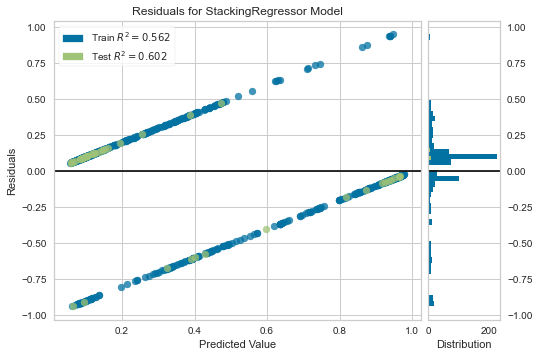

In [21]:
plot_model(stacker)

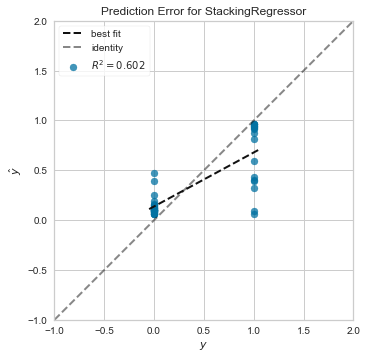

In [22]:
plot_model(stacker, plot='error')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 30 iterations


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


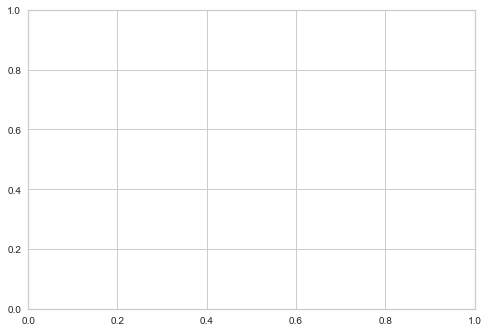

In [23]:
plot_model(stacker, plot='learning')

In [ ]:
plot_model(tuned_top_models[0], plot='feature')

In [ ]:
predict_model(stacker);

In [ ]:
final_model = finalize_model(stacker)

In [ ]:
predict_model(final_model)

In [ ]:
test_predictions = predict_model(final_model, data=test)
test_predictions['Label'] = test_predictions.Label.round(0).astype(int)
test_predictions.head()

In [ ]:
save_model(final_model, 'Final Model 17.11.2020')